# 02-Transformers

Deep Learning runs on Transformers. After completing this lab you should have a good grasp of how they work.

### Questions?

* Do you have any questions about the lecture, exercises, or anything else?


### Plan for today

1. Discuss together Transformer and Vision Transformer (on whiteboard)

2. Discuss selected your questions about the two papers (we can also send them to the authors)

3. Work on the exercises from the previous lab (~30 minutes including discussion) 

4. I will describe plan for this and the next lab, and you will start working on this. The next lab will be fully devoted to working on implementing Vision Transformer (so no need to do it as homework, there will be time to finish exercises if you didn't manage to this time).

## References:

* Transformer paper: https://arxiv.org/abs/1706.03762
* Vision Transformer paper: https://arxiv.org/abs/2010.11929
* Tutorial on Transformers we will roughly follow: http://jalammar.github.io/illustrated-transformer/

Other credits:

* https://github.com/asyml/vision-transformer-pytorch

* https://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb




# 1. Introduction

(Mostly done on whiteboard)

1. Walk through Transformers 

2. Walk through Vision Transformer

# 2. Paper discussion

Note: this type of questions represents well what you can see during the exam. The goal is to help you read critically work, which is important for any deep learning practitioner.

* Let's talk about the papers. Do you have any questions to the authors?
* Yours questions:

* My questions:
  - What do you think about biases of GPT-3 (e.g. race vs sentiment score). How do we mitigate this? Should we mitigate this?

  - Why does "Overall, GPT-3 displays reasonable proficiency at moderately complex arithmetic in few-shot, one-shot, and even zero-shot settings."? 

  - Why is GPT-3 weak on sentence comparison tasks?

  - What is the LAMBADA dataset (this is very specific and we are not expecting you to know the answer. But it is a good opportunity to dig into one of the most interesting datasets)?

  - What does it mean to say that language models are meta-learners?

  - Why does Vision Transformer underperform ResNet on ImageNet and other smaller (by the way, saying ImageNet is a small dataset is historically funny) datasets?

  - What is the CLS token?

  - Why does GPT-3 achieve zero-shot generalization? 

  - Why did the authors of Vision Transformer follow closely the original Transformer architecture?


# 3. Setup

(Run and hide the Section)

In [ ]:
# 0. Clone, install & configure some software

! git clone https://github.com/asyml/vision-transformer-pytorch
! git clone https://github.com/gmum/dl-mo-2021
! pip install dotmap

import sys
sys.path.append("vision-transformer-pytorch")
sys.path.append("vision-transformer-pytorch/src")

Cloning into 'vision-transformer-pytorch'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 154 (delta 71), reused 115 (delta 32), pack-reused 0
Receiving objects: 100% (154/154), 185.68 KiB | 1.67 MiB/s, done.
Resolving deltas: 100% (71/71), done.
Cloning into 'dl-mo-2021'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 65 (delta 17), reused 38 (delta 7), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [ ]:
# 1. Generic imports (TODO: Deduplicate / order)
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import math
import matplotlib.pylab as plt
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import torch.nn as nn
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
import os
import torch
import gc; 
import torch.nn as nn
import numpy as np

import PIL


from dotmap import DotMap

In [ ]:
# 2. Imports from Vision Transformer repository

from utils import setup_device, accuracy, MetricTracker, TensorboardWriter
from src.model import VisionTransformer
from src.config import get_b16_config, get_train_config
from src.checkpoint import load_checkpoint
from src.data_loaders import *
from src.model import *

In [ ]:
# 3. Make sure you have ViT pretrained weights (see 01-transfer-learning for reference)

In [ ]:
# 4. Define config for ViT we will be using

# Some defaults taken form README.md in https://github.com/asyml/vision-transformer-pytorch
config = get_b16_config(DotMap())
# config.image_size = 384
# config.num_classes = 10
config.image_size = 384
config.lr = 0.005
config.warmup_steps = 10 
config.wd = 0.0
config.num_classes = 1000
config.train_steps_per_epoch = 100
config.epochs = 3
config.batch_size = 8
config.num_workers = 1
config.data_dir = "data"
# Make sure this path exists!
config.checkpoint_path = "drive/MyDrive/imagenet21k+imagenet2012_ViT-B_16.pth" 
assert len(config.checkpoint_path) == 0 or os.path.exists(config.checkpoint_path)
config.dataset = "ImageNet"

In [ ]:
# 5. Load ViT
vit_state_dict = load_checkpoint(config.checkpoint_path)
class VisionTransformer(nn.Module):
    """ Vision Transformer """
    def __init__(self,
                 image_size=(256, 256),
                 patch_size=(16, 16),
                 emb_dim=768,
                 mlp_dim=3072,
                 num_heads=12,
                 num_layers=12,
                 num_classes=1000,
                 attn_dropout_rate=0.0,
                 dropout_rate=0.1,
                 feat_dim=None):
        super(VisionTransformer, self).__init__()
        h, w = image_size

        # embedding layer
        fh, fw = patch_size
        gh, gw = h // fh, w // fw
        num_patches = gh * gw
        self.embedding = nn.Conv2d(3, emb_dim, kernel_size=(fh, fw), stride=(fh, fw))
        # class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, emb_dim))

        # transformer
        self.transformer = Encoder(
            num_patches=num_patches,
            emb_dim=emb_dim,
            mlp_dim=mlp_dim,
            num_layers=num_layers,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
            attn_dropout_rate=attn_dropout_rate)

        # classfier
        self.classifier = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        emb = self.embedding(x)     # (n, c, gh, gw)
        emb = emb.permute(0, 2, 3, 1)  # (n, gh, hw, c)
        b, h, w, c = emb.shape
        emb = emb.reshape(b, h * w, c)

        # prepend class token
        cls_token = self.cls_token.repeat(b, 1, 1)
        emb = torch.cat([cls_token, emb], dim=1)

        # transformer
        feat = self.transformer(emb)

        # classifier
        logits = self.classifier(feat[:, 0])
        return logits
        
model = VisionTransformer(
          image_size=(config.image_size, config.image_size),
          patch_size=(config.patch_size, config.patch_size),
          emb_dim=config.emb_dim,
          mlp_dim=config.mlp_dim,
          num_heads=config.num_heads,
          num_layers=config.num_layers,
          num_classes=config.num_classes,
          attn_dropout_rate=config.attn_dropout_rate,
          dropout_rate=config.dropout_rate)
IMG_SIZE = (384, 384)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)
model.load_state_dict(vit_state_dict)
_ = model.to(device)

In [ ]:
# 6. Grab a demo image and imagenet labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

--2021-03-02 19:19:49--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2021-03-02 19:19:49 (80.0 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]

--2021-03-02 19:19:49--  https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/hirotomusiker/schwert_colab_data_storage/raw/master/images/vit_dem

# 4. Implementing and Visualizing Vision Transformer

We will walk together through implementing Vision Transformer step by step. This is a worthwhile exercise, as Transformers illustrate the most important concepts in current deep learning, both technologically and conceptually.

Note: We will probably run out of time. We will continue working on this next time.


## Exercise 0: Can you make Vision Transformer to make a "stupid" error?

Try 3 examples, and report your worst finding. Please pick a single well-defined class from imagenet_labels (e.g. sombrero). Why do you think the model made an error (if you found an example where it does).

Inference Result:
['monastery\n', 'church, church_building\n', 'dome\n']


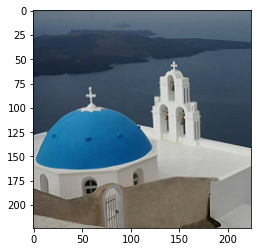

In [ ]:
# end-to-end inference
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)
output = model(img_tensor)
cls_ordered = [imagenet_labels[int(i)] for i in np.argsort(output.detach().numpy())[0]]
print("Inference Result:")
print(cls_ordered[-3:])
plt.imshow(img)

## Exercise 1: Text positional encoding

Please implement the PE function based on https://arxiv.org/abs/1706.03762 (Section 3.5).

Positional encoding encodes the position of each token using a certain mechanism. This helps the model to reason about the spatial relationships between tokens. 

Hint: Try to achieve the visual effect first (as shown in the Figure). It is easy to get some details wrong.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = # ?
        pe[:, 1::2] = # ?
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

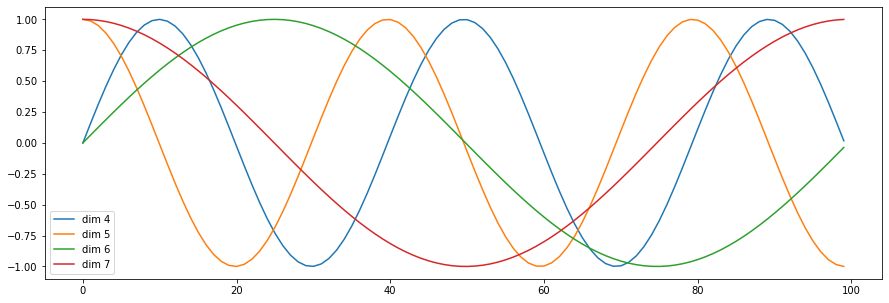

In [ ]:
# Test your solution
assert np.allclose(y[0, 0:8, 4].numpy(), np.array([0., 0.15782663, 0.31169716, 0.45775455, 0.5923377, 0.7120732 , 0.81395954, 0.89544296]))
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
# This shows different features as a function of input index
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## Exercise 2: Vision positional encoding 

(a) Please implement Positional encoding in Vision Transformer based on https://arxiv.org/abs/2010.11929. If you implement it correctly, you should observe a cross-like pattern. 

(b) Reproduce Figure 7b from the paper (https://arxiv.org/abs/2010.11929) using the provided snippet.

(c) Answer question: Why didn't the authors use positional features like in text positional encoding?

Hint: This class is used in the Vision Transformer as indicated by this pseudocode:

```{python}
    def forward(self, x):
        emb = self.embedding(x)     # (n, c, gh, gw)
        emb = emb.permute(0, 2, 3, 1)  # (n, gh, hw, c)
        b, h, w, c = emb.shape
        emb = emb.reshape(b, h * w, c)

        # prepend class token
        cls_token = self.cls_token.repeat(b, 1, 1)
        emb = torch.cat([cls_token, emb], dim=1)

        # transformer
        emb = self.pos_embedding(emb)

        # ...
```

In [ ]:
class PositionEmbs(nn.Module):
    def __init__(self, num_patches, emb_dim, dropout_rate=0.1):
        super(PositionEmbs, self).__init__()
        self.pos_embedding = # ?
        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        out = # ?

        if self.dropout:
            out = self.dropout(out)

        return out

In [ ]:
# Create class and load weights into it
pos_emb = PositionEmbs(576, config.emb_dim)
name = "transformer.pos_embedding.pos_embedding"
pos_emb.pos_embedding[:] = vit_state_dict[name][:]
N_patches = 24
P = pos_emb.pos_embedding.detach().numpy()[:, 1:, :].reshape(-1, 768)

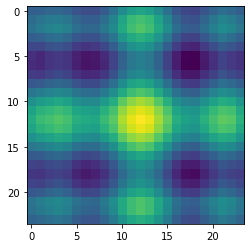

In [ ]:
M = np.zeros(shape=[N_patches, N_patches])
A =  P[N_patches*N_patches//2 + N_patches//2] # Pick middle token
for i in range(N_patches):
  for j in range(N_patches):
    B = P[N_patches*i + j]
    M[i, j] = np.dot(A, B) / (np.linalg.norm(A) * np.linalg.norm(B))
plt.imshow(M)

## Exercise 3: Visualize filters of Vision Transformer

Please visualize filters learned by Vision Transformer (Figure 7a in https://arxiv.org/pdf/2010.11929.pdf). Your image doesn't have to be perfect

Hint: You will need to use PCA.

## Exercise 4: Self-attention (that's where is the action!)

(a) Please implement Self-attention in Vision Transformer (which is identical to self-attention in Transformer).

(b) Please visualize attention of the CLS token, and of 200th token. How do they differ?

Hint: Follow http://jalammar.github.io/illustrated-transformer/ 

In [ ]:
class LinearGeneral(nn.Module):
    # Feed-forward implementation
    def __init__(self, in_dim=(768,), feat_dim=(12, 64)):
        super(LinearGeneral, self).__init__()

        self.weight = nn.Parameter(torch.randn(*in_dim, *feat_dim))
        self.bias = nn.Parameter(torch.zeros(*feat_dim))

    def forward(self, x, dims):
        # If you are consuded by what it does, take a look at https://numpy.org/doc/stable/reference/generated/numpy.tensordot.html
        # For us it is just matrix multiplication where you specify along which axes of a tensor you want to "multiply"
        a = torch.tensordot(x, self.weight, dims=dims) + self.bias
        return a

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim, heads=8, dropout_rate=0.1):
        super(SelfAttention, self).__init__()
        self.heads = heads
        self.head_dim = in_dim // heads
        self.scale = self.head_dim ** 0.5

        self.query = # ? (use LinearGeneral class)
        self.key = # ? (use LinearGeneral class)
        self.value = # ? (use LinearGeneral class)
        self.out = # ? (use LinearGeneral class)

        if dropout_rate > 0:
            self.dropout = nn.Dropout(dropout_rate)
        else:
            self.dropout = None

    def forward(self, x):
        # ?

        return out

In [ ]:
# Create yours, and copy ViT's, self-attention, and then load weights of the latter into the former
vit_sa = model.transformer.encoder_layers[0].attn
sa = SelfAttention(in_dim=sequence.shape[-1], heads=config.num_heads)
for module in ['key', 'query', 'value', 'out']:
  getattr(sa, module).weight[:] = getattr(vit_sa, module).weight[:]
  getattr(sa, module).bias[:] = getattr(vit_sa, module).bias[:]

In [ ]:
# Some boilerplate code to process the example image until we have the sequence that we can input into self-attention
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)
emb = model.embedding(img_tensor)     # (n, c, gh, gw)
emb = emb.permute(0, 2, 3, 1)  # (n, gh, hw, c)
b, h, w, c = emb.shape
emb = emb.reshape(b, h * w, c)
cls_token = model.cls_token.repeat(b, 1, 1)
emb = torch.cat([cls_token, emb], dim=1)
sequence = model.transformer.pos_embedding(emb)
# Almost there!
sequence = model.transformer.encoder_layers[0].norm1(sequence)

In [ ]:
# Test your implementation (should reproduce ViT self-attention)
output = sa(sequence).detach().numpy()
output_2 = vit_sa(sequence).detach().numpy()
assert np.allclose(output, output_2)

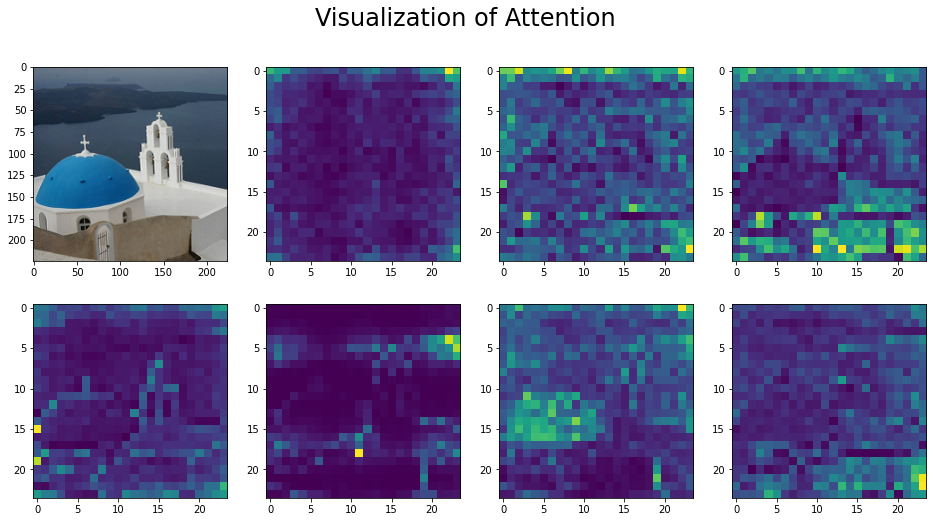

In [ ]:
# Visualize attention matrix
sa(sequence)
attention_matrix = sa.attn_weights[0]
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 0, 1:].reshape((24, 24)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# Homework

(Please rememebr it is due Thursday midnight via email)

* (1p) Completed ipython notebook for the previous lab as a printed pdf

All asserts have to pass. All images have to be included in the print-out.

* (1p) Read https://arxiv.org/pdf/2103.00020.pdf and https://arxiv.org/abs/2102.12092 and answer the same set of questions (one sentence is fine) as before:

```
  * What problem did the authors propose to tackle (pay close attention to Introduction)
  
  * What was previosly popular approach to solve this problem?
  
  * What is the method and motivation for using this method?
  
  * What are topics for the future work?
  
  * What question you would ask the author (we will discuss some during the next class)
```

Remember that the final exam will be partly based on understanding these papers that we read together.

* (1p) Come up with two ideas for a mini-project that uses either CLIP or Vision Transformer in each group (if you do not have a group yet that's fine and just please e-mail me). During next class we will discuss different ideas